# Imports

In [1]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from itertools import product
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import os

# Configs

## Constant Values

In [2]:
# Add your input and output path
INPUT_PATH = 'datasets/'

START_DATE = '2023-01-01'
END_DATE = '2023-04-30'

train_list = ['prev_day_demand', 'month', 'day_month', 'day_week']

test_size = 0.25

## Functions

In [3]:
def load_data(path, start_date: str, end_date: str):
    dataset = pd.read_parquet(path)
    start_date = datetime.date.fromisoformat(start_date)
    end_date = datetime.date.fromisoformat(end_date)
    clean_dataset = dataset[(dataset['tpep_pickup_datetime'].dt.date >= start_date) &
                            (dataset['tpep_pickup_datetime'].dt.date <= end_date)]
    # Add a new column for pick-up date
    clean_dataset['PU_date'] = pd.to_datetime(clean_dataset['tpep_pickup_datetime'].dt.date)
    return clean_dataset

In [4]:
def labeling(dataset):
    dataset_labels = dataset.groupby(['PULocationID', 'PU_date'])['PU_date'].count().to_frame('Demand')\
        .sort_values(['PULocationID', 'PU_date'], ascending=[True, True]).reset_index()\
        .rename(columns={'PULocationID': 'Location', 'PU_date': 'Date'})

    locations = pd.DataFrame(dataset_labels['Location'].unique(), columns=['Location'])
    dates = pd.DataFrame(dataset_labels['Date'].unique(), columns=['Date'])
    # create a DataFrame for all locations and dates
    loc_date_df = locations.merge(dates, how='cross').\
        sort_values(['Location', 'Date'], ascending=[True, True]).reset_index(drop=True)
    # Fill the DataFrame with demands
    labels_df = loc_date_df.merge(dataset_labels, how='left', on=['Location', 'Date']).fillna(value=0)

    return labels_df

In [5]:
def date_format_modifier(data):  # Year/Month/Day
    data['month'] = data['Date'].dt.month
    data['day_month'] = data['Date'].dt.day
    data['day_week'] = data['Date'].dt.dayofweek
    return data

In [6]:
def train_test_splitting(dataset, test_size):
    start_date = dataset['Date'].min()
    end_date = dataset['Date'].max()
    all_days = end_date - start_date

    train_df = dataset[(dataset['Date'] - start_date) < (1 - test_size) * all_days]
    test_df = dataset[(dataset['Date'] - start_date) >= (1 - test_size) * all_days]

    return train_df, test_df

In [7]:
def evaluate(metric, metric_name, true_values, predicted_values):
    print(f'{metric_name} : {metric(true_values, predicted_values)}')

In [8]:
def add_features(data):  # run after merging datasets and modifing date
    # Lag features
    data['prev_day_demand'] = data.groupby(['Location'])['Demand'].shift(1)

    data = data.dropna()

    return data

In [9]:
def grid_search(model, test_parameters, train_data, cv = None):
    gs = GridSearchCV(estimator = model, param_grid = test_parameters, scoring = 'neg_root_mean_squared_error', cv = cv, n_jobs = -1)
    gs.fit(train_data[train_list], train_data['Demand'])
    return gs.best_params_, gs.best_score_

In [10]:
def model_predict(model, train_data, test_data):

    model.fit(train_data[train_list], train_data['Demand'])


    yhat_train = model.predict(train_data[train_list])
    yhat_test = model.predict(test_data[train_list])

    return yhat_train, yhat_test

In [11]:
def predict_visualizer(train_data, test_data, yhat_train, yhat_test):

    predicted_train_df = train_data.copy(deep = True)
    predicted_test_df = test_data.copy(deep = True)
    predicted_train_df['Predicted'] = yhat_train
    predicted_test_df['Predicted'] = yhat_test

    train_data = train_data.groupby('day_year')['Demand'].sum()
    test_data = test_data.groupby('day_year')['Demand'].sum()
    predicted_train_df = predicted_train_df.groupby('day_year')['Predicted'].sum()
    predicted_test_df = predicted_test_df.groupby('day_year')['Predicted'].sum()

    plt.title('Train')
    plt.plot(train_data)
    plt.plot(predicted_train_df)
    plt.legend(["Real Value", "Predicted"], loc ="lower right")
    plt.show()

    plot_length = len(test_data)
    plt.title('Test')
    plt.plot(test_data)
    plt.plot(predicted_test_df)
    plt.legend(["Real Value", "Predicted"], loc ="lower right")
    plt.show()

In [12]:
def evaluation(model_name, train_data, test_data, yhat_train, yhat_test):
    print(f'{model_name} train scores:')


    evaluate(mean_absolute_error, 'MAE', train_data['Demand'], yhat_train)
    evaluate(mean_squared_error, 'MSE', train_data['Demand'], yhat_train)

    print(f'{model_name} test scores:')


    evaluate(mean_absolute_error, 'MAE', test_data['Demand'], yhat_test)
    evaluate(mean_squared_error, 'MSE', test_data['Demand'], yhat_test)


In [13]:
def day_of_year_modifier(dataset):
    dataset['day_year'] = 0
    start_date = dataset['Date'].min()

    for index, row in dataset.iterrows():
        # Get the day and month values from the current row
        curr_date = row['Date']
        day_number = (curr_date - start_date).days

        dataset.at[index, 'day_year'] = day_number
    return dataset

# Load dataset

In [14]:
rides_df = load_data(INPUT_PATH, START_DATE, END_DATE)

C:\Users\bardia\AppData\Local\Temp\ipykernel_23352\1456684031.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_dataset['PU_date'] = pd.to_datetime(clean_dataset['tpep_pickup_datetime'].dt.date)


# Preprocess

In [15]:
labeled_df = labeling(rides_df)

In [16]:
featured_df = add_features(labeled_df)

In [ ]:
dated_df = date_format_modifier(featured_df)
dated_df = day_of_year_modifier(dated_df)

In [18]:
train_df, test_df = train_test_splitting(dated_df, test_size)

In [ ]:
train_df

,Location,Date,Demand,prev_day_demand,month,day_month,day_week,day_year
1,1,2023-01-02,31.0,40.0,1,2,0,0
2,1,2023-01-03,27.0,31.0,1,3,1,1
3,1,2023-01-04,7.0,27.0,1,4,2,2
4,1,2023-01-05,15.0,7.0,1,5,3,3
5,1,2023-01-06,11.0,15.0,1,6,4,4
...,...,...,...,...,...,...,...,...
31411,265,2023-04-02,84.0,73.0,4,2,6,90
31412,265,2023-04-03,120.0,84.0,4,3,0,91
31413,265,2023-04-04,134.0,120.0,4,4,1,92
31414,265,2023-04-05,133.0,134.0,4,5,2,93


# Model Training

## **Gradient Boosting Regressor**

### Tune Model

In [ ]:
param_test = {'max_depth':range(2,10,2), 'min_child_weight':range(1,6,2)}

params = {"objective": "reg:squarederror", "tree_method": "gpu_hist", 'n_estimators':140, 'learning_rate':0.1, 'max_depth':5,
         'min_child_weight':1, 'gamma':0, 'subsample':0.8, 'colsample_bytree':0.8, 'seed':27}

best_params, best_score = grid_search(model = xgb.XGBRegressor(**params), test_parameters = param_test, train_data = train_df, cv = 5)
print(best_params, best_score)

{'max_depth': 2, 'min_child_weight': 3} -129.96563188441945


In [ ]:
params.update(best_params)
param_test = {'gamma':[i/10.0 for i in range(0,5)]}
best_params, best_score = grid_search(model = xgb.XGBRegressor(**params), test_parameters = param_test, train_data = train_df, cv = 5)
print(best_params, best_score)

{'gamma': 0.0} -238.60198873503435


In [ ]:
params.update(best_params)
param_test = {'subsample':[i/10.0 for i in range(6,10)], 'colsample_bytree':[i/10.0 for i in range(6,10)]}
best_params, best_score = grid_search(model = xgb.XGBRegressor(**params), test_parameters = param_test, train_data = train_df, cv = 5)
print(best_params, best_score)

{'colsample_bytree': 0.6, 'subsample': 0.9} -237.0204546297031


In [ ]:
params.update(best_params)
param_test = {'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]}
best_params, best_score = grid_search(model = xgb.XGBRegressor(**params), test_parameters = param_test, train_data = train_df, cv = 5)
print(best_params, best_score)

{'reg_alpha': 1} -237.02005974356038


In [ ]:
params.update(best_params)
param_test = {'n_estimators':list(range(1000, 5001, 500)), 'learning_rate':[0.01]}
best_params, best_score = grid_search(model = xgb.XGBRegressor(**params), test_parameters = param_test, train_data = train_df, cv = 5)
print(best_params, best_score)

{'learning_rate': 0.01, 'n_estimators': 1500} -236.59626847393665


In [ ]:
params.update(best_params)
param_test = {'n_estimators':list(range(15000, 20001, 500)), 'learning_rate':[0.001]}
best_params, best_score = grid_search(model = xgb.XGBRegressor(**params), test_parameters = param_test, train_data = train_df, cv = 5)
print(best_params, best_score)

{'learning_rate': 0.001, 'n_estimators': 15000} -236.53642284774014


### Train With Tuned Parameters

In [19]:
dtrain_reg = xgb.DMatrix(train_df[train_list].values, train_df['Demand'].values, enable_categorical=True)
dtest_reg = xgb.DMatrix(test_df[train_list].values, test_df['Demand'].values, enable_categorical=True)

#params.update(best_params)
params = {'learning_rate': 0.001, 'n_estimators': 15000, 'reg_alpha': 1, 'colsample_bytree': 0.6,
          'subsample': 0.9, 'gamma': 0.0, 'max_depth': 2, 'min_child_weight': 5}
model = xgb.XGBRegressor(**params)
yhat_train, yhat_test = model_predict(model, train_df, test_df)

### Visualization

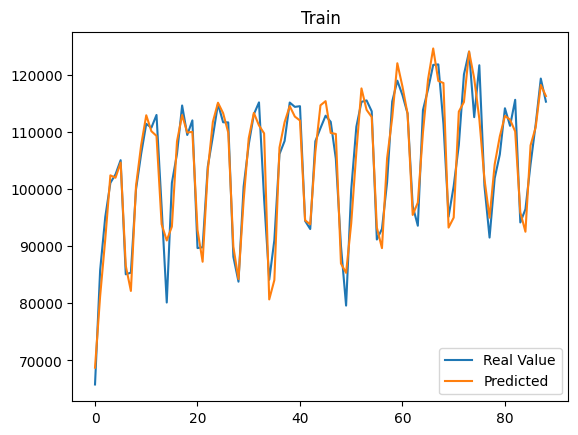

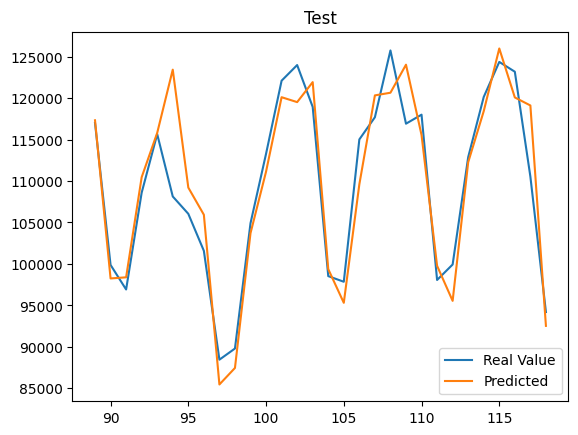

In [21]:
predict_visualizer(train_df, test_df, yhat_train, yhat_test)

### Evaluation

In [22]:
evaluation('XGB', train_df, test_df, yhat_train, yhat_test)  # for whole data

XGB train scores:
MAE : 69.44329103411245
MSE : 37079.702824234904
XGB test scores:
MAE : 72.26973286009472
MSE : 37897.452541212646


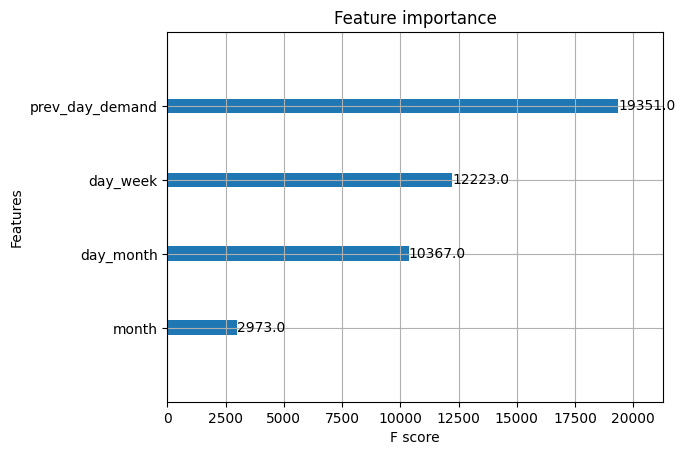

In [23]:
xgb.plot_importance(model)
plt.show()